In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#pip install ISLP

In [9]:
#import necessary modules
import os
import numpy as np
import csv
from tabulate import tabulate
import sys
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ISLP import confusion_table
from functools import partial
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

from statsmodels.api import GLM
from ISLP.models import ModelSpec as MS
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = pd.read_csv('/content/drive/My Drive/415/datasci 415/full_dataset.csv')
df['winner_2020_encoded'] = df['winner_2020'].apply(lambda x: 1 if x == 'Democrat' else 0)
df['State'] = df['State'].astype('category')

## simple with one hot encoding state

In [11]:
#models with all relevant predictors, one hot encoding state
allvars = df.columns.drop(['total_votes_2020', 'prop_favored_dem_2020', 'county_names_with_casing', 'winner_2020', 'County', 'winner_2020_encoded'])
y = df['winner_2020_encoded']
X = df[allvars]
X =  pd.get_dummies(X, columns=['State'], drop_first=True)
for col in X.select_dtypes(include=[bool]).columns:
    X[col] = X[col].astype(int)

In [12]:
#logistic -- warnings with State
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm.fit()
#print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [13]:
#logistic confusion table
y_pred = np.array([1]*X_test.shape[0])
probs = results.predict(exog=X_test)
y_pred[probs>0.5] = 1
confusion_table(y_pred, y_test)

Truth,0,1
Predicted,,
0,0,0
1,528,100


In [14]:
#lda confusion table
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
confusion_table(y_pred, y_test)

Truth,0,1
Predicted,,
0,520,12
1,8,88


In [15]:
#qda confusion table
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Truth,0,1
Predicted,,
0,513,53
1,15,47


In [16]:
#naive bayes confusion table
NB = GaussianNB()
NB.fit(X_train, y_train)
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, y_test)

Truth,0,1
Predicted,,
0,512,61
1,16,39


In [17]:
#knn confusion table
knn1 = KNeighborsClassifier(n_neighbors=10)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
confusion_table(y_pred, y_test)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b8942cb2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory


Truth,0,1
Predicted,,
0,509,63
1,19,37


## simple without state

In [18]:
#model with all relevant predictors, REMOVE state:
allvars2 = df.columns.drop(['total_votes_2020', 'prop_favored_dem_2020', 'county_names_with_casing', 'winner_2020', 'County', 'winner_2020_encoded', 'State'])
y = df['winner_2020_encoded']
X = df[allvars2]
for col in X.select_dtypes(include=[bool]).columns:
    X[col] = X[col].astype(int)

In [19]:
#logistic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm.fit()
#print(results.summary())

In [20]:
#logistic
y_pred = np.array([1]*X_test.shape[0])
probs = results.predict(exog=X_test)
y_pred[probs>0.5] = 1
confusion_table(y_pred, y_test)

Truth,0,1
Predicted,,
0,0,0
1,518,110


In [21]:
#LDA
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
confusion_table(y_pred, y_test)

Truth,0,1
Predicted,,
0,513,10
1,5,100


In [22]:
#pretty LDA

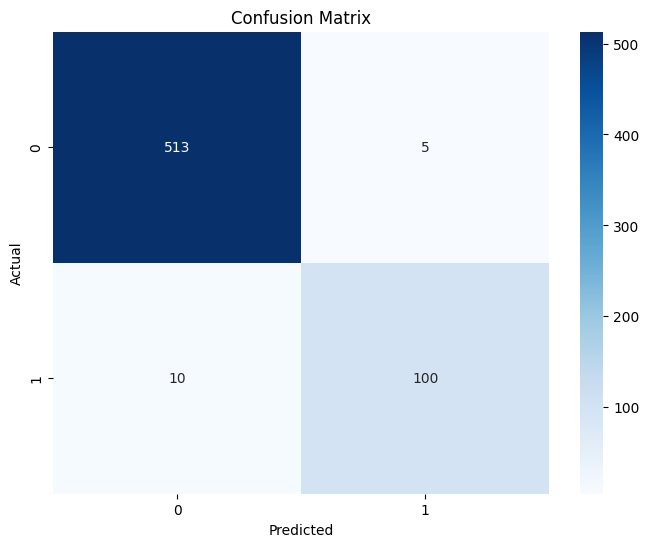

In [23]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#QDA
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, y_test)

In [ ]:
#naive bayes
NB = GaussianNB()
NB.fit(X_train, y_train)
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, y_test)

In [ ]:
#KNN
knn1 = KNeighborsClassifier(n_neighbors=10)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
confusion_table(y_pred, y_test) #cross validate for n

## model selection (logistic)

In [ ]:
#removed state already
allvars = df.columns.drop(['total_votes_2020', 'prop_favored_dem_2020',
                           'county_names_with_casing', 'winner_2020', 'County',
                           'winner_2020_encoded', 'State'])
y = df['winner_2020_encoded']
X = df[allvars]
for col in X.select_dtypes(include=[bool]).columns:
    X[col] = X[col].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#logistic
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm.fit()
sigma2 = glm.fit().scale
neg_Cp = partial(nCp, sigma2)

In [ ]:
design = MS(X.columns).fit(X)
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(X.columns))

In [ ]:
Cp = sklearn_selected(GLM, strategy, scoring=neg_Cp)
Cp.fit(X_train, y_train)
Cp.selected_state_

#two predictors for logistic: ('prop_favored_dem_2012', 'prop_favored_dem_2016')

('prop_favored_dem_2012', 'prop_favored_dem_2016')

In [ ]:
y = df['winner_2020_encoded']
X = df[['prop_favored_dem_2012', 'prop_favored_dem_2016']]
for col in X.select_dtypes(include=[bool]).columns:
    X[col] = X[col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm.fit()

y_pred = np.array([1]*X_test.shape[0])
probs = results.predict(exog=X_test)
y_pred[probs>0.5] = 1
confusion_table(y_pred, y_test)

#still just always predicts 1 -- pretty sus

Truth,0,1
Predicted,,
0,0,0
1,523,105


## model selection - LDA

In [ ]:
#LDA

lda = LDA(store_covariance=True)
sigma2 = lda.fit(X_train, y_train)
sigma2 = lda.covariance_
neg_Cp = partial(nCp, sigma2)

design = MS(X.columns).fit(X)
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(X.columns))

Cp = sklearn_selected(GLM, strategy, scoring=neg_Cp)
Cp.fit(X_train, y_train)
Cp.selected_state_

('prop_favored_dem_2012', 'prop_favored_dem_2016')

In [ ]:
#same predictors as logisitic: 'prop_favored_dem_2012', 'prop_favored_dem_2016'
y = df['winner_2020_encoded']
X = df[['prop_favored_dem_2012', 'prop_favored_dem_2016']]
for col in X.select_dtypes(include=[bool]).columns:
    X[col] = X[col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
confusion_table(y_pred, y_test)

#best model so far

Truth,0,1
Predicted,,
0,506,14
1,5,103


In [ ]:
y_pred_train = lda.predict(X_train)
confusion_table(y_pred_train, y_train) 2508 2452

Truth,0,1
Predicted,,
0,2060,39
1,17,392


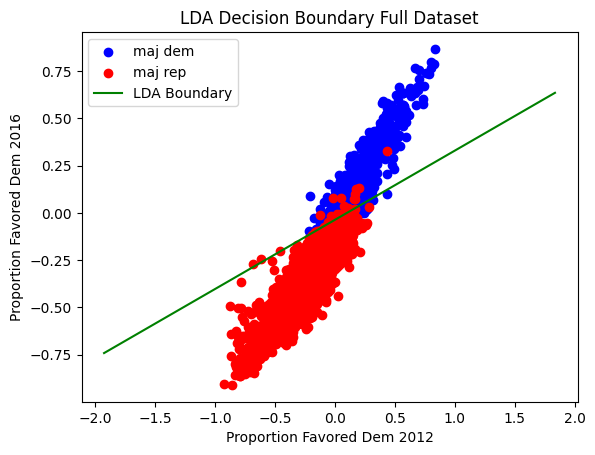

In [ ]:
Dem = X[y == 1]
Rep = X[y == 0]

plt.scatter(Dem['prop_favored_dem_2012'], Dem['prop_favored_dem_2016'], color='blue', label='maj dem')
plt.scatter(Rep['prop_favored_dem_2012'], Rep['prop_favored_dem_2016'], color='red', label='maj rep')

plt.xlabel('Proportion Favored Dem 2012')
plt.ylabel('Proportion Favored Dem 2016')

#Calculate decision boundary line
x1_range = np.linspace(X['prop_favored_dem_2012'].min() - 1, X['prop_favored_dem_2012'].max() + 1, 100)
w = lda.coef_
b = lda.intercept_
x2_boundary = - (w[0][0] / w[0][1]) * x1_range - (b/w[0][1])
plt.plot(x1_range, x2_boundary, color='green', label='LDA Boundary')

plt.title('LDA Decision Boundary Full Dataset')
plt.legend()
plt.show()

In [ ]:
Dem = X_test[y_test == 1]
Rep = X_test[y_test == 0]

plt.scatter(Dem['prop_favored_dem_2012'], Dem['prop_favored_dem_2016'], color='blue', label='maj dem')
plt.scatter(Rep['prop_favored_dem_2012'], Rep['prop_favored_dem_2016'], color='red', label='maj rep')

plt.xlabel('Proportion Favored Dem 2012')
plt.ylabel('Proportion Favored Dem 2016')

#Calculate decision boundary line
x1_range = np.linspace(X_test['prop_favored_dem_2012'].min() - 1, X_test['prop_favored_dem_2012'].max() + 1, 100)
w = lda.coef_
b = lda.intercept_
x2_boundary = - (w[0][0] / w[0][1]) * x1_range - (b/w[0][1])
plt.plot(x1_range, x2_boundary, color='green', label='LDA Boundary')

plt.title('LDA Decision Boundary Test Set')
plt.legend()
plt.show()